<a href="https://colab.research.google.com/github/Alokik-29/Project_1/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
#Install dependencies
!pip install librosa soundfile matplotlib numpy

In [44]:
import os,sys,random,math
from pathlib import Path
import numpy as np
import pandas as pd
import librosa,librosa.display
import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display  import Audio,display
from sklearn.model_selection import train_test_split

#reproducibility
SEED=42
random.seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#mtplotlib defaults
plt.rcParams["figure.figsize"]=(10,4)
plt.rcParams["axes.grid"]=True

print("Librosa:", librosa.__version__)
print("Torchaudio:", torchaudio.__version__)


Librosa: 0.11.0
Torchaudio: 2.8.0+cu126


In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [46]:
dataset_path="/kaggle/input/ravdess-emotional-speech-audio"

In [47]:
#emotion labell mapping from RAVDESS dataset
emotion_map={
    "01":"neutral",
    "02":"calm",
    "03":"happy",
    "04":"sad",
    "05":"angry",
    "06":"fearful",
    "07":"disgust",
    "08":"surprised"
}

In [48]:
#getting all audio file path
audio_files=list(Path(dataset_path).rglob("*.wav"))

#extracting labels from file name
labels=[]
for file in audio_files:

    filename = file.name  # just the filename, e.g., "03-01-01-01-01-01-01.wav"
    emotion_code = filename.split("-")[2]  # third part indicates emotion
    labels.append(emotion_map[emotion_code])

df=pd.DataFrame({
    "file_path":audio_files,
    "label":labels
})
# Keep only valid labels
valid_labels = list(emotion_map.values())
df = df[df['label'].isin(valid_labels)].reset_index(drop=True)

print(f"Total samples: {len(df)}")
print(df['label'].value_counts())

df=df.sample(frac=1,random_state=SEED).reset_index(drop=True)
df.head()

Total samples: 2880
label
surprised    384
disgust      384
fearful      384
sad          384
happy        384
calm         384
angry        384
neutral      192
Name: count, dtype: int64


,file_path,label
0,/kaggle/input/ravdess-emotional-speech-audio/A...,calm
1,/kaggle/input/ravdess-emotional-speech-audio/a...,fearful
2,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
3,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
4,/kaggle/input/ravdess-emotional-speech-audio/A...,sad


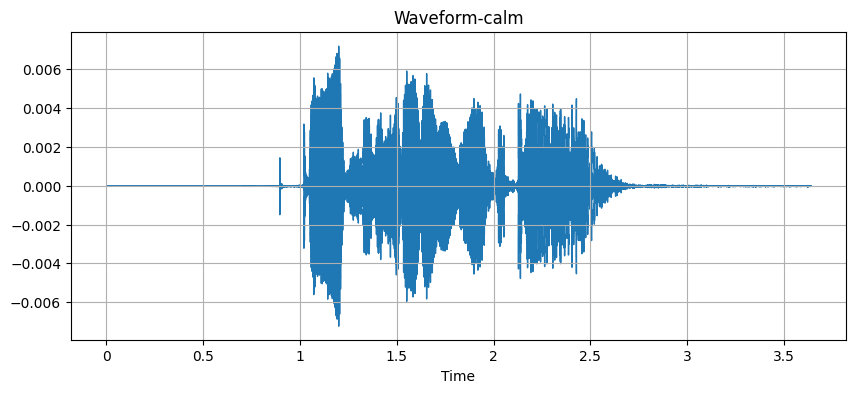

In [49]:
#pick a random sample
sample_file=df['file_path'][0]
sample_label=df['label'][0]

#displaay audio player

#load waveform
y,sr=librosa.load(sample_file,sr=16000)
y = np.expand_dims(y, axis=0)
plt.figure()
librosa.display.waveshow(y,sr=sr)
plt.title(f"Waveform-{sample_label}")
plt.show()

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

#Define a transform function to convert audio to Mel Spectrogram
def mel_spectrogram_transform(y,sr,n_mels=64,n_fft=1024,hop_length=512):
  # Convert numpy array to torch tensor
  waveform=torch.tensor(y).unsqueeze(0)
  mel_spec=torchaudio.transforms.MelSpectrogram(
      sample_rate=sr,
      n_fft=n_fft,
      hop_length=hop_length,
      n_mels=n_mels
  )(waveform)
  # Convert power spectrogram to log scale (dB)
  mel_spec=torchaudio.transforms.AmplitudeToDB()(mel_spec)
  return mel_spec


In [51]:
class RAVDESSDataset(Dataset):
    def __init__(self, df, feature_extractor, target_length=16000):  # 1s audio default
        self.df = df
        self.feature_extractor = feature_extractor
        self.target_length = target_length
        self.label_list = list(emotion_map.values())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = str(self.df.iloc[idx]['file_path'])
        label = self.df.iloc[idx]['label']

        if label not in self.label_list:
            raise ValueError(f"Invalid label found: {label}")

        # Load audio at 16kHz
        y, sr = librosa.load(file_path, sr=16000)
        y = torch.tensor(y)

        # Pad or truncate to target_length
        if y.shape[0] < self.target_length:
            pad_len = self.target_length - y.shape[0]
            y = torch.nn.functional.pad(y, (0, pad_len))
        else:
            y = y[:self.target_length]

        # Return raw waveform
        label_idx = self.label_list.index(label)
        return y, label_idx



In [52]:
from sklearn.model_selection import train_test_split
from transformers import ASTForAudioClassification, ASTFeatureExtractor


train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)

feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

train_dataset = RAVDESSDataset(train_df, feature_extractor)
test_dataset = RAVDESSDataset(test_df, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [53]:
# Load model directly
from transformers import AutoFeatureExtractor

extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

# x_batch: list of raw waveforms from DataLoader
inputs = [extractor(y.numpy(), sampling_rate=16000, return_tensors="pt")["input_values"] for y in x_batch]
inputs = torch.cat(inputs, dim=0).to(device)  # batch the inputs

outputs = model(inputs).logits



AssertionError: choose a window size 400 that is [2, 128]

In [ ]:
from torch import nn

num_labels = len(emotion_map)
model.classifier = nn.Linear(model.config.hidden_size, num_labels)
model.to(device)

In [ ]:
batch = next(iter(train_loader))
x_batch, y_batch = batch

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    mel = x_batch[i].numpy().reshape(1, 64, -1)  # reshape to (1, n_mels, time)
    label_idx = y_batch[i].item()
    label = list(emotion_map.values())[label_idx]

    axes[i].imshow(mel.squeeze(0), origin='lower', aspect='auto', cmap='viridis')
    axes[i].set_title(label)
    axes[i].axis('off')
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (only train classifier head first)
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-4)

# Optional: learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
#Training Loop
num_epochs=10
model.train()

for num_epoch in range(num_epochs):
  running_loss=0.0
  correct=0
  total=0

  for i,(inputs,labels) in enumerate(train_loader):
    inputs=inputs.to(device)
    labels=labels.to(device)

    optimizer.zero_grad()
    outputs=model(inputs).logits
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  scheduler.step()
  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100*correct/total:.2f}%")